In [1]:
import json
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
import numpy as np
from PIL import Image
import torch
from ultralytics.utils.metrics import mask_iou
import itertools
import cv2
import matplotlib.image as mpimg

os.environ['KMP_DUPLICATE_LIB_OK']='True' # mkl 라이브러리 중복 실행 방지
# Ignore warnings
warnings.filterwarnings('ignore')
# pandas dataframe display
pd.set_option('display.max_columns', None)

In [59]:
anno = pd.read_csv('../data/imaterialist-fashion-2020-fgvc7/train.csv')
with open('../data/imaterialist-fashion-2020-fgvc7/label_descriptions.json', 'r') as file:
    labels = json.load(file)

categories = pd.DataFrame(labels['categories'])
attributes = pd.DataFrame(labels['attributes'])

In [3]:
anno.shape

(333401, 6)

In [4]:
# anno.head()

In [5]:
# categories

In [6]:
# attributes.head(15)

In [7]:
# attributes.tail(15)

In [8]:
attributes.supercategory.unique()

array(['nickname', 'silhouette', 'waistline', 'length', 'neckline type', 'opening type', 'non-textile material type', 'leather', 'textile finishing, manufacturing techniques', 'textile pattern', 'animal'], dtype=object)

In [9]:
# attributes.name.unique()

In [10]:
attributes.shape

(294, 4)

In [11]:
anno = pd.merge(anno, categories[['id', 'name', 'supercategory']], left_on='ClassId', right_on=['id'], how='left')

In [12]:
# EncodedPixels - 마스킹 관련 annotation
anno.head(2)

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,id,name,supercategory
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317",6,pants,lowerbody
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317",0,"shirt, blouse",upperbody


## 데이터 형식 변환을 위해 필요한 절차

---

## 1. 옷의 종류와 특징 파악 (category & attributes)  
- 데이터 셋의 범위 파악
#### : 각 class 별로 어떤 attribute들이 있는지 살펴보기

In [13]:
id_to_name = pd.Series(attributes.name.values, index=attributes.id).to_dict()

# function to convert IDs to names
def ids_to_names(ids):
    if pd.isna(ids):
        return np.nan
    names = [id_to_name.get(int(id_), 'Unknown') for id_ in ids.split(',')]
    return ', '.join(names)

# Apply the function to the AttributesIds column
anno['AttributesNames'] = anno['AttributesIds'].apply(ids_to_names)

In [14]:
id_to_name[115]

'symmetrical'

In [15]:
# anno.head()

In [16]:
anno_tmp = anno.copy()

# attribute를 string 형태에서 list 형태로 변환
anno_tmp['AttributesIds'] = anno_tmp['AttributesIds'].str.split(',')
anno_tmp['AttributesNames'] = anno_tmp['AttributesNames'].str.split(',')

In [17]:
# attribute를 row-wise로 길게 늘린다
exploded_df = anno_tmp.explode('AttributesIds')
# 'name', 'AttributesIds' 기준으로 unique pair만 골라낸다
unique_pairs = exploded_df[['name', 'AttributesIds']].drop_duplicates()
unique_pairs.reset_index(drop=True, inplace=True)
unique_pairs = unique_pairs.loc[unique_pairs['AttributesIds'].notna()]
unique_pairs['AttributesIds'] = unique_pairs['AttributesIds'].astype(int)
unique_pairs.rename(columns={"name":"class_name"}, inplace=True)

In [18]:
# exploded_df.head()

In [19]:
# unique_pairs.head(20)

In [20]:
# 각 attribute ID를 human readable한 텍스트로 변환
pairs = pd.merge(unique_pairs, attributes, left_on='AttributesIds', right_on='id', how='left')
pairs.sort_values(by=['class_name', 'id'], inplace=True)

In [21]:
pairs.head()

,class_name,AttributesIds,id,name,supercategory,level
941,applique,182,182,round (neck),neckline type,1
1171,bead,182,182,round (neck),neckline type,1
884,bead,183,183,v-neck,neckline type,1
871,bead,190,190,scoop (neck),neckline type,1
1267,bead,192,192,plunging (neckline),neckline type,1


In [22]:
pairs.to_csv("../data/clothes_pairs.csv", index=False)

In [23]:
for c in pairs.class_name.unique():
    print(c)

applique
bead
cape
cardigan
coat
collar
dress
flower
fringe
hood
jacket
jumpsuit
lapel
neckline
pants
pocket
ruffle
shirt, blouse
shorts
skirt
sleeve
sweater
top, t-shirt, sweatshirt
vest
zipper


- class name 별로 attribute이 명확히 구분되지는 않는다

In [24]:
# pairs.loc[pairs['class_name']=='pants', 'name'].values

In [25]:
# pairs.loc[pairs['class_name']=='jacket', 'name'].values

##### example

- [trucker (jacket)](https://www.billyreid.com/cdn/shop/files/f23_203-482_moleskin-tupelo-trucker-jacket_olive_201_A_3000x.jpg)

- [houndstooth (pattern)](https://www.thecuttingclass.com/wp-content/uploads/2011/03/593bfb3e455e5_houndstooth.jpg)


## 2. 상위 / 하위 카테고리의 관계 정의
- 보다 온전한 데이터를 위한 전처리 작업
#### : annotation 살펴보기

- Run-Length Encoding (RLE) 포맷
    - 예) 6068157 7 6073371 20 6078584 34
    - 2D를 일차원으로 변형했을 때 6068157번째에 오는 픽셀부터 7개의 픽셀들이 annotate
    - 효율적인 데이터 저장을 위한 선택

In [26]:
# anno.head(2)

In [27]:
# anno.loc[0, 'EncodedPixels']

In [28]:
tmp = anno.loc[anno['ImageId']=='2f18aaab685a98876504a0f32d4c1d8e']
tmp.reset_index(inplace=True, drop=True)

- 이때, `garment parts`나 `closures`와 같이 옷의 한 부분을 지칭하는 레이블들은 `shirt, blouse`와 같은 다른 레이블의 annotation의 일부분으로 표시된다

In [29]:
# tmp

In [30]:
def create_single_mask(image, annoations, class_ids):
    masks = []
    shape = image.shape

    # Initialize numpy array with shape same as image size
    height, width = shape[:2]
    mask = np.zeros((height, width)).reshape(-1)

    # Iterate over encoded pixels and create mask
    for segment, (pixel_str, class_id) in enumerate(zip(annoations, class_ids)):
        splitted_pixels = list(map(int, pixel_str.split()))
        pixel_starts = splitted_pixels[::2]
        run_lengths = splitted_pixels[1::2]
        assert max(pixel_starts) < mask.shape[0]
        for pixel_start, run_length in zip(pixel_starts, run_lengths):
            pixel_start = int(pixel_start) - 1
            run_length = int(run_length)
            mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4
    masks.append(mask.reshape((height, width), order='F'))
    return masks

In [15]:
def show_image_with_mask(image_path, mask):
    # Load the original image
    image = Image.open(image_path)
    
    # Plotting the original image
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # Plotting the mask on top of the image
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap='jet', alpha=0.5)  # Overlaying the mask with transparency
    plt.title('Image with Mask')
    plt.axis('off')
    
    plt.show()

In [ ]:
image = mpimg.imread('../data/imaterialist-fashion-2020-fgvc7/train/2f18aaab685a98876504a0f32d4c1d8e.jpg')
masks = create_single_mask(image, tmp['EncodedPixels'], tmp['id'])

show_image_with_mask('../data/imaterialist-fashion-2020-fgvc7/train/2f18aaab685a98876504a0f32d4c1d8e.jpg', masks[0])

## 3. 추천 서비스에 활용할 단위의 데이터로 변환
- 서비스와의 연계성을 고려한 데이터 변환

### 옷 추천 서비스의 단위는 자켓, 바지 등 온전한 옷감의 단위

- 주머니, 소매, 깃 등은 셔츠나 블라우스 등과 같은 상의 카테고리와 함께 고려되어야 한다
    - 하위 카테고리 (주머니, 소매, 깃)의 annotation은 상위 카테고리의 annotation과 겹치게 만들어져 있음
- 또한, 같은 주머니라도, 바지 주머니와 상의 주머니가 함께 한 이미지에 존재함
- 따라서 하위와 상위 카테고리들의 pair 생성을 통해 온전한 옷 전체의 특징을 고려할 수 있어야 함

In [13]:
def create_separate_masks(annoations, class_ids, height, width):
    masks = []

    for segment, (pixel_str, class_id) in enumerate(zip(annoations, class_ids)):
        mask = np.zeros((height, width)).reshape(-1)
        splitted_pixels = list(map(int, pixel_str.split()))
        pixel_starts = splitted_pixels[::2]
        run_lengths = splitted_pixels[1::2]
        assert max(pixel_starts) < mask.shape[0]
        for pixel_start, run_length in zip(pixel_starts, run_lengths):
            pixel_start = int(pixel_start) - 1
            run_length = int(run_length)
            mask[pixel_start:pixel_start+run_length] = 1
        masks.append(mask.reshape((height, width), order='F'))
    return masks

In [36]:
masks = create_separate_masks(tmp['EncodedPixels'], tmp['id'], tmp['Height'].values[0], tmp['Width'].values[0])

In [37]:
masks[2].shape

(5120, 3184)

In [38]:
print("수트 특징 : ")
print(tmp.loc[8, 'AttributesNames'])

수트 특징 : 
blazer, symmetrical, regular (fit), normal waist, above-the-hip (length), single breasted, no non-textile material, lining, plain (pattern)


In [ ]:
show_image_with_mask('../data/imaterialist-fashion-2020-fgvc7/train/2f18aaab685a98876504a0f32d4c1d8e.jpg', masks[8])

In [39]:
print("자켓 주머니 특징 : ")
print(tmp.loc[5, 'AttributesNames'])

자켓 주머니 특징 : 
welt (pocket)


In [ ]:
show_image_with_mask('../data/imaterialist-fashion-2020-fgvc7/train/2f18aaab685a98876504a0f32d4c1d8e.jpg', masks[5])

In [40]:
print("바지 특징 : ")
print(tmp.loc[9, 'AttributesNames'])

바지 특징 : 
symmetrical, peg, regular (fit), normal waist, maxi (length), fly (opening), no non-textile material, no special manufacturing technique, plain (pattern)


In [ ]:
show_image_with_mask('../data/imaterialist-fashion-2020-fgvc7/train/2f18aaab685a98876504a0f32d4c1d8e.jpg', masks[9])

In [41]:
print("바지 주머니 특징 : ")
print(tmp.loc[10, 'AttributesNames'])

바지 주머니 특징 : 
curved (pocket)


In [ ]:
show_image_with_mask('../data/imaterialist-fashion-2020-fgvc7/train/2f18aaab685a98876504a0f32d4c1d8e.jpg', masks[10])

In [42]:
print("벨트 특징 : ")
print(tmp.loc[11, 'AttributesNames'])

벨트 특징 : 
nan


In [ ]:
show_image_with_mask('../data/imaterialist-fashion-2020-fgvc7/train/2f18aaab685a98876504a0f32d4c1d8e.jpg', masks[11])

In [43]:
print("벨트 버클의 특징 : ")
print(tmp.loc[12, 'AttributesNames'])

벨트 버클의 특징 : 
nan


In [ ]:
show_image_with_mask('../data/imaterialist-fashion-2020-fgvc7/train/2f18aaab685a98876504a0f32d4c1d8e.jpg', masks[12])

### Annotation pair 생성하기
1. annotation을 binary mask 형태로 변환
2. 한 이미지 내에서, 90% 이상 겹치는 한 쌍의 annotation 존재 여부 탐색
3. 해당 annotation pair 중 범위가 더 큰 annotation을 기준으로 통합

In [44]:
def flatten_mask(mask):

    flattened_mask = mask.flatten()
    mask_tensor = np.reshape(flattened_mask, (1, -1))

    mask_tensor = torch.tensor(mask_tensor, dtype=torch.float32)
    return mask_tensor

In [45]:
def check_overlap(mask1, mask2, threshold=0.9):
    """
    Determine if the overlap between two masks covers more than `threshold` of the smaller mask.
    """
    # Calculate IoU using the mask_iou function
    iou = mask_iou(mask1, mask2).item()
    if iou==0:
        return False
    
    # Calculate the areas of the masks
    area1 = mask1.sum().item()
    area2 = mask2.sum().item()
    
    # Determine the smaller mask
    smaller_area = min(area1, area2)
    
    # Calculate the intersection area based on IoU and union
    intersection = iou * (area1 + area2) / (1 + iou)
    
    # Check if the intersection covers more than threshold of the smaller mask
    if intersection / smaller_area > threshold:
        return True
    else:
        return False

In [46]:
image = mpimg.imread('../data/imaterialist-fashion-2020-fgvc7/train/{}.jpg'.format(tmp.ImageId.unique()[0]))
masks = create_separate_masks(tmp['EncodedPixels'], tmp['id'], tmp['Height'].values[0], tmp['Width'].values[0])

combinations = list(itertools.combinations(range(len(masks)), 2))

pairs = list()

# 모든 combination 고려
for comb in combinations:
    mask1 = masks[comb[0]]
    mask2 = masks[comb[1]]
    # 비교를 위해 flatten
    flat1 = flatten_mask(mask1)
    flat2 = flatten_mask(mask2)
    # 두 binary mask들 중 작은 mask가 큰 mask와 90% 이상 픽셀을 공유하는지 여부 체크
    if check_overlap(flat1, flat2):
        # 둘 중 큰 mask를 선별하여 대표 mask로 설정
        if mask1.sum() > mask2.sum():
            pairs.append([comb[0], comb])
        else:
            pairs.append([comb[1], comb])

In [47]:
pairs

[[2, (0, 2)],
 [2, (1, 2)],
 [2, (2, 3)],
 [8, (4, 8)],
 [8, (5, 8)],
 [8, (6, 8)],
 [8, (7, 8)],
 [8, (8, 16)],
 [9, (9, 10)]]

In [48]:
print("셔츠")
tmp.loc[[0,1,2,3]]

셔츠


,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,id,name,supercategory,AttributesNames
0,2f18aaab685a98876504a0f32d4c1d8e,6918332 12 6923450 27 6928569 31 6933687 35 69...,5120,3184,28,163,28,collar,garment parts,shirt (collar)
1,2f18aaab685a98876504a0f32d4c1d8e,9008680 2 9013799 6 9018919 6 9024038 7 902915...,5120,3184,31,160,31,sleeve,garment parts,wrist-length
2,2f18aaab685a98876504a0f32d4c1d8e,4937594 6 4942715 17 4947835 25 4952955 28 495...,5120,3184,0,"115,136,145,225,295,316,317",0,"shirt, blouse",upperbody,"symmetrical, regular (fit), no waistline, sing..."
3,2f18aaab685a98876504a0f32d4c1d8e,4937594 6 4942715 17 4947835 25 4952955 28 495...,5120,3184,31,160,31,sleeve,garment parts,wrist-length


In [ ]:
print('자켓')
tmp.loc[[4,5,6,7,8,16]]

In [ ]:
print('바지')
tmp.loc[[9, 10]]

- 소매, 주머니와 같은 `하위 항목`의 특징을 하나의 컬럼에 추가

In [ ]:
attributes.tail(30)

In [50]:
tmp['second_AttributesIds'] = ''

In [51]:
tmp.head(1)

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,id,name,supercategory,AttributesNames,second_AttributesIds
0,2f18aaab685a98876504a0f32d4c1d8e,6918332 12 6923450 27 6928569 31 6933687 35 69...,5120,3184,28,163,28,collar,garment parts,shirt (collar),


In [52]:
pairs

[[2, (0, 2)],
 [2, (1, 2)],
 [2, (2, 3)],
 [8, (4, 8)],
 [8, (5, 8)],
 [8, (6, 8)],
 [8, (7, 8)],
 [8, (8, 16)],
 [9, (9, 10)]]

In [55]:
main_pairs = list(set([i[0] for i in pairs]))

for mp in main_pairs:
    pair = [i[1] for i in pairs if i[0]==mp]
    print("옷 번호 {}과 관련된 옷감 : ".format(mp), pair)
    flat_pair = list(set([element for tuple_ in pair for element in tuple_]))
    sub_category = [i for i in flat_pair if i!=mp]
    print("옷 번호 {}의 하위 카테고리 : ".format(mp), sub_category)
    sub_attributes = tmp.loc[sub_category, 'AttributesIds'].values
    sub_attributes = list(set(','.join(sub_attributes).split(',')))
    sub_attributes = ','.join(sub_attributes)
    print("옷 번호 {}의 하위 특징 id : ".format(mp), sub_attributes)
    tmp.loc[mp, 'second_AttributesIds'] = sub_attributes

    print("-"*20)


옷 번호 8과 관련된 옷감 :  [(4, 8), (5, 8), (6, 8), (7, 8), (8, 16)]
옷 번호 8의 하위 카테고리 :  [4, 5, 6, 7, 16]
옷 번호 8의 하위 특징 id :  160,204,174,219
--------------------
옷 번호 9과 관련된 옷감 :  [(9, 10)]
옷 번호 9의 하위 카테고리 :  [10]
옷 번호 9의 하위 특징 id :  223
--------------------
옷 번호 2과 관련된 옷감 :  [(0, 2), (1, 2), (2, 3)]
옷 번호 2의 하위 카테고리 :  [0, 1, 3]
옷 번호 2의 하위 특징 id :  160,163
--------------------


In [56]:
main_pairs

[8, 9, 2]

In [57]:
pair

[(0, 2), (1, 2), (2, 3)]

In [58]:
flat_pair, sub_category

([0, 1, 2, 3], [0, 1, 3])

In [59]:
sub_attributes

'160,163'

In [60]:
tmp

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,id,name,supercategory,AttributesNames,second_AttributesIds
0,2f18aaab685a98876504a0f32d4c1d8e,6918332 12 6923450 27 6928569 31 6933687 35 69...,5120,3184,28,163,28,collar,garment parts,shirt (collar),
1,2f18aaab685a98876504a0f32d4c1d8e,9008680 2 9013799 6 9018919 6 9024038 7 902915...,5120,3184,31,160,31,sleeve,garment parts,wrist-length,
2,2f18aaab685a98876504a0f32d4c1d8e,4937594 6 4942715 17 4947835 25 4952955 28 495...,5120,3184,0,"115,136,145,225,295,316,317",0,"shirt, blouse",upperbody,"symmetrical, regular (fit), no waistline, sing...","160,163"
3,2f18aaab685a98876504a0f32d4c1d8e,4937594 6 4942715 17 4947835 25 4952955 28 495...,5120,3184,31,160,31,sleeve,garment parts,wrist-length,
4,2f18aaab685a98876504a0f32d4c1d8e,6278549 1 6283666 3 6288784 4 6293902 4 629902...,5120,3184,29,174,29,lapel,garment parts,notched (lapel),
5,2f18aaab685a98876504a0f32d4c1d8e,8895205 3 8900318 10 8905431 17 8910545 23 891...,5120,3184,32,219,32,pocket,garment parts,welt (pocket),
6,2f18aaab685a98876504a0f32d4c1d8e,9305606 2 9310725 4 9315844 6 9320963 8 932608...,5120,3184,31,"160,204",31,sleeve,garment parts,"wrist-length, set-in sleeve",
7,2f18aaab685a98876504a0f32d4c1d8e,4937636 9 4942744 27 4947860 36 4952983 39 495...,5120,3184,31,"160,204",31,sleeve,garment parts,"wrist-length, set-in sleeve",
8,2f18aaab685a98876504a0f32d4c1d8e,4549114 15 4554223 46 4559332 76 4564441 106 4...,5120,3184,4,"17,115,136,142,146,225,295,311,317",4,jacket,upperbody,"blazer, symmetrical, regular (fit), normal wai...","160,204,174,219"
9,2f18aaab685a98876504a0f32d4c1d8e,4304404 6 4309517 18 4314629 32 4319742 44 432...,5120,3184,6,"115,126,136,142,154,230,295,316,317",6,pants,lowerbody,"symmetrical, peg, regular (fit), normal waist,...",223


In [61]:
len(combinations)

136

In [62]:
tmp.shape

(17, 11)

### 전체 데이터 셋에 적용하기

- `00.preprocess_annotations.py` 참고
- 실행 방법 : `python 00.preprocess_annotations.py` (소요시간 대략 10시간)

In [ ]:
def search_attribute_pairs(tmp_df, image_base_path='../data/imaterialist-fashion-2020-fgvc7/train'):
    tmp = tmp_df.reset_index(drop=True).copy()
    image = mpimg.imread(os.path.join(image_base_path, tmp.ImageId.unique()[0]+'.jpg'))
    # binary mask 생성
    masks = create_separate_masks(tmp['EncodedPixels'], tmp['id'], tmp['Height'].values[0], tmp['Width'].values[0])

    combinations = list(itertools.combinations(range(len(masks)), 2))

    pairs = list()

    # 모든 combination 고려
    for comb in combinations:
        # binary mask 선택
        mask1 = masks[comb[0]]
        mask2 = masks[comb[1]]
        # 비교를 위해 flatten
        flat1 = flatten_mask(mask1)
        flat2 = flatten_mask(mask2)
        # 두 binary mask들 중 작은 mask가 큰 mask와 90% 이상 픽셀을 공유하는지 여부 체크
        if check_overlap(flat1, flat2):
            # 둘 중 큰 mask를 선별하여 대표 mask로 설정
            if mask1.sum() > mask2.sum():
                pairs.append([comb[0], comb])
            else:
                pairs.append([comb[1], comb])
    return pairs

In [ ]:
def merge_attribute_pairs(tmp_df, pairs):
    tmp = tmp_df.reset_index(drop=True).copy()
    # attribute이 없는 경우도 존재하기 때문에, string 값으로 변환
    tmp.loc[tmp['AttributesIds'].isna(), 'AttributesIds'] = ''
    main_pairs = list(set([i[0] for i in pairs]))

    for mp in main_pairs:
        # 상위 카테고리가 포함된 pair 선택
        pair = [i[1] for i in pairs if i[0]==mp]
        # 상위 카테고리를 제외한 다른 id만 선택 == 하위 카테고리
        flat_pair = list(set([element for tuple_ in pair for element in tuple_]))
        sub_category = [i for i in flat_pair if i!=mp]
        # 하위 카테고리들의 attribute를 하나로 병합
        sub_attributes = tmp.loc[sub_category, 'AttributesIds'].values
        sub_attributes = list(set(','.join(sub_attributes).split(',')))
        sub_attributes = ','.join(sub_attributes)
        # 상위 카테고리의 second attribute로 저장
        tmp.loc[mp, 'second_AttributesIds'] = sub_attributes

    return tmp

In [ ]:
# # 전체 데이터를 새로 만들 예정
# new_anno = pd.DataFrame()

# # 각 이미지 단위로 iterate
# for image in tqdm(anno['ImageId'].unique()):
#     # 한 이미지 단위 df
#     tmp_df = anno.loc[anno['ImageId']==image]
#     # pair 찾기
#     pairs = search_attribute_pairs(tmp_df)
#     if len(pairs)>0:
#         # attribute들을 합쳐서 update
#         tmp_df = merge_attribute_pairs(tmp_df, pairs)
#     # 새로운 df에 추가
#     new_anno = pd.concat([new_anno, tmp_df])

### read

In [2]:
file_path = '../data/imaterialist-fashion-2020-fgvc7/outputs.json'

data = []

# Open the file for reading
with open(file_path, 'r') as file:
    for line in file:
        # Parse the JSON data from each line
        json_line = json.loads(line)
        
        # Optional: append the parsed JSON data to a list for further processing
        data.append(json_line)

In [3]:
pd.DataFrame(data[0])

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,second_AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317",None
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317",163
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163,None
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204",None
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219,None
5,00000663ed1ff0c4e0132b9b9ac53f6e,11464158 10 11469372 30 11474586 43 11479800 4...,5214,3676,32,219,None
6,00000663ed1ff0c4e0132b9b9ac53f6e,5910568 31 5915775 65 5920982 69 5926189 73 59...,5214,3676,31,"160,204",None
7,00000663ed1ff0c4e0132b9b9ac53f6e,6421446 292 6426657 298 6431867 305 6437078 31...,5214,3676,29,174,None
8,00000663ed1ff0c4e0132b9b9ac53f6e,4566382 8 4571592 25 4576803 41 4582013 58 458...,5214,3676,4,"17,115,136,145,149,225,295,311,317","219,204,160,174"


In [4]:
pd.DataFrame(data[1])

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,second_AttributesIds
0,0000fe7c9191fba733c8a69cfaf962b7,2201176 1 2203623 3 2206071 5 2208518 8 221096...,2448,2448,33,190,None
1,0000fe7c9191fba733c8a69cfaf962b7,1343707 9 1346138 27 1348569 44 1351000 62 135...,2448,2448,1,"0,115,145,146,295,316,317",190


In [5]:
data = [pd.DataFrame(data[i]) for i in range(len(data))]

In [6]:
anno = pd.concat(data, axis=0)

In [7]:
anno.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,second_AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317",None
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317",163
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163,None
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204",None
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219,None


In [8]:
anno.shape

(200047, 7)

## 4. 이미지 cropping을 위한 전처리
- 효율적인 search를 위한 데이터 정규화
#### : Bounding box를 생성하고, 이미지를 crop하여 개별 저장

- 이때, 소매나 주머니 같은 하위 카테고리는 제거 (이미 관련 attribute을 상위카테고리의 second-attribute에 저장)

In [9]:
## 27번 이후는 옷의 파츠들에 대한 카테고리 
## 해당 카테고리는 불필요
anno = anno.loc[anno['ClassId']<27]

In [10]:
anno.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,second_AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317",None
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317",163
8,00000663ed1ff0c4e0132b9b9ac53f6e,4566382 8 4571592 25 4576803 41 4582013 58 458...,5214,3676,4,"17,115,136,145,149,225,295,311,317","219,204,160,174"
1,0000fe7c9191fba733c8a69cfaf962b7,1343707 9 1346138 27 1348569 44 1351000 62 135...,2448,2448,1,"0,115,145,146,295,316,317",190
1,0002ec21ddb8477e98b2cbb87ea2e269,2287509 4 2290504 12 2290588 26 2293501 18 229...,3000,1997,10,"102,128,142,150,229,295,301,318",182


In [11]:
anno.shape

(97924, 7)

##### cropping 방법

1. mask
2. bbox

- 왜 bbox?
    - 주변 context까지 참고 할 수 있도록 이미지 crop

In [ ]:
tmp = anno.loc[anno['ImageId']=='2f18aaab685a98876504a0f32d4c1d8e']

masks = create_separate_masks(tmp['EncodedPixels'], tmp['ClassId'], tmp['Height'].values[0], tmp['Width'].values[0])

# show_image_with_mask('../data/imaterialist-fashion-2020-fgvc7/train/2f18aaab685a98876504a0f32d4c1d8e.jpg', masks[2])

In [17]:
def find_bounding_box(mask):
    """
    Find the bounding box of non-zero pixels in a mask.
    
    :param mask: The binary mask.
    :return: A tuple (x_min, y_min, x_max, y_max) representing the bounding box.
    """
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    
    return x_min, y_min, x_max, y_max

- 약 30분 소요

In [29]:
bboxes = list()

for i in tqdm(anno.ImageId.unique()):
    tmp = anno.loc[anno['ImageId']==i]
    masks = create_separate_masks(tmp['EncodedPixels'], tmp['ClassId'], tmp['Height'].values[0], tmp['Width'].values[0])
    bbox = [find_bounding_box(i) for i in masks]
    bboxes.extend(bbox)
    # break

anno.reset_index(drop=True, inplace=True)

  0%|          | 0/27375 [00:00<?, ?it/s]

In [19]:
i

'00000663ed1ff0c4e0132b9b9ac53f6e'

In [32]:
tmp

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,second_AttributesIds
97923,ffffbf7014a9e408bfbb81a75bc70638,63365 36 63852 77 64343 85 64838 89 65332 94 6...,500,375,10,"102,128,142,150,295,308,317",",157"


In [39]:
anno['bbox'] = bboxes  # bbox 컬럼 추가
anno['bbox'] = anno['bbox'].apply(lambda x: str(x))  # bbox를 문자열로 변환
anno.to_csv("../data/imaterialist-fashion-2020-fgvc7/clothes_final.csv", index=False)

In [63]:
# 위 function이 오래 걸리기 때문에,
# 시간 관계상 미리 만들어 놓은 data frame 활용

def listify(string, encap_type="()"):
    return [int(num) for num in string.strip(encap_type).split(', ')]

anno = pd.read_csv("../data/imaterialist-fashion-2020-fgvc7/clothes_final.csv")

# 처음 읽을 때, pandas dataframe에서 list가 아닌 string 값으로 인식하기 때문에 변환 필요
anno['bbox'] = [listify(i) for i in anno['bbox']]
# anno['bbox_big'] = [listify(i) for i in anno['bbox_big']]

In [64]:
anno.head(2)

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,second_AttributesIds,bbox
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317",NaN,"[1163, 3923, 2839, 5212]"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317",163,"[1212, 1371, 2394, 3978]"


In [65]:
def enlarge_bounding_box(bbox, img_shape, scale=0.05):
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    
    # Calculate enlargement
    enlarge_width = width * scale
    enlarge_height = height * scale
    
    # Apply enlargement
    x_min = max(0, x_min - enlarge_width // 2)
    y_min = max(0, y_min - enlarge_height // 2)
    x_max = min(img_shape[1], x_max + enlarge_width // 2)
    y_max = min(img_shape[0], y_max + enlarge_height // 2)
    
    return int(x_min), int(y_min), int(x_max), int(y_max)

In [66]:
bigger_bboxes = [enlarge_bounding_box(box, [h, w]) for box, h, w in zip(anno['bbox'], anno['Height'], anno['Width'])]

In [67]:
anno['bbox_big'] = bigger_bboxes

bbox가 알맞게 만들어졌는지 테스트

In [68]:
def draw_bounding_box(image, bbox, color=(0, 255, 0), thickness=20):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Draw the rectangle on the image
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color[::-1], thickness)  # Convert color to RGB
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide the axis

In [69]:
anno.head(2)

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,second_AttributesIds,bbox,bbox_big
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317",NaN,"[1163, 3923, 2839, 5212]","(1122, 3891, 2880, 5214)"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317",163,"[1212, 1371, 2394, 3978]","(1183, 1306, 2423, 4043)"


In [70]:
tmp = anno.loc[anno['ImageId']=="00000663ed1ff0c4e0132b9b9ac53f6e"]

In [71]:
masks = create_separate_masks(tmp['EncodedPixels'], tmp['ClassId'], tmp['Height'].values[0], tmp['Width'].values[0])

In [72]:
# show_image_with_mask('../data/imaterialist-fashion-2020-fgvc7/train/00000663ed1ff0c4e0132b9b9ac53f6e.jpg', masks[0])

In [73]:
# draw = draw_bounding_box(cv2.imread("../data/imaterialist-fashion-2020-fgvc7/train/00000663ed1ff0c4e0132b9b9ac53f6e.jpg"), tmp['bbox'][0])

In [74]:
# draw = draw_bounding_box(cv2.imread("../data/imaterialist-fashion-2020-fgvc7/train/00000663ed1ff0c4e0132b9b9ac53f6e.jpg"), tmp['bbox_big'][0])

In [75]:
# show_image_with_mask('../data/imaterialist-fashion-2020-fgvc7/train/00000663ed1ff0c4e0132b9b9ac53f6e.jpg', masks[1])

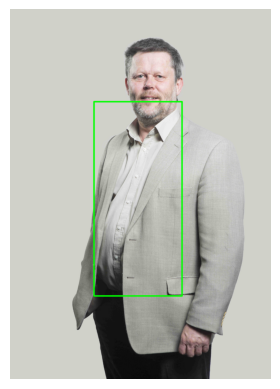

In [76]:
# draw = draw_bounding_box(cv2.imread("../data/imaterialist-fashion-2020-fgvc7/train/00000663ed1ff0c4e0132b9b9ac53f6e.jpg"), tmp['bbox_big'][1])

In [77]:
def calculate_bbox_metrics(bbox):
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min
    area = width * height
    
    return {'width': width, 'height': height, 'area': area}

- bounding box 관련 정보 추가

In [78]:
anno.head(2)

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,second_AttributesIds,bbox,bbox_big
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317",NaN,"[1163, 3923, 2839, 5212]","(1122, 3891, 2880, 5214)"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317",163,"[1212, 1371, 2394, 3978]","(1183, 1306, 2423, 4043)"


In [80]:
bbox_metrics = [calculate_bbox_metrics(i) for i in anno['bbox_big']]

In [82]:
anno = pd.concat([anno, pd.DataFrame(bbox_metrics)], axis=1)

- attribute과 classId 이름 다시 붙이기

In [85]:
# category
anno = pd.merge(anno, categories[['id', 'name', 'supercategory']], left_on='ClassId', right_on=['id'], how='left')

In [87]:
# attributionId 전처리
def clean_attributes(attr_str):
    if isinstance(attr_str, float):
        return np.nan
    l = attr_str.split(',')
    l = [i for i in l if i != '']
    s = ','.join(l)
    if s=='':
        return np.nan
    else:
        return s
    

anno.loc[anno['AttributesIds']=='', 'AttributesIds'] = np.nan

anno['second_AttributesIds'] = anno['second_AttributesIds'].fillna(np.nan)
anno.loc[anno['second_AttributesIds']=='', 'second_AttributesIds'] = np.nan

In [92]:
anno['AttributesNames'] = [ids_to_names(i) for i in anno['AttributesIds']]

In [93]:
anno['second_AttributesIds'] = [clean_attributes(i) for i in anno['second_AttributesIds']]
anno['second_AttributesNames'] = [ids_to_names(i) for i in anno['second_AttributesIds']]

In [95]:
anno.head(2)

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds,second_AttributesIds,bbox,bbox_big,width,height,area,id,name,supercategory,AttributesNames,second_AttributesNames
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317",NaN,"[1163, 3923, 2839, 5212]","(1122, 3891, 2880, 5214)",1758,1323,2325834,6,pants,lowerbody,"symmetrical, regular (fit), low waist, maxi (l...",NaN
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317",163,"[1212, 1371, 2394, 3978]","(1183, 1306, 2423, 4043)",1240,2737,3393880,0,"shirt, blouse",upperbody,"symmetrical, regular (fit), normal waist, abov...",shirt (collar)


In [96]:
anno.to_csv("../data/imaterialist-fashion-2020-fgvc7/clothes_final.csv", index=False)